# MixUp augmentation for image classification

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/03/06<br>
**Last modified:** 2023/07/24<br>
**Description:** Data augmentation using the mixup technique for image classification.

## Introduction

_mixup_ is a *domain-agnostic* data augmentation technique proposed in [mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)
by Zhang et al. It's implemented with the following formulas:

![](https://i.ibb.co/DRyHYww/image.png)

(Note that the lambda values are values with the [0, 1] range and are sampled from the
[Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution).)

The technique is quite systematically named. We are literally mixing up the features and
their corresponding labels. Implementation-wise it's simple. Neural networks are prone
to [memorizing corrupt labels](https://arxiv.org/abs/1611.03530). mixup relaxes this by
combining different features with one another (same happens for the labels too) so that
a network does not get overconfident about the relationship between the features and
their labels.

mixup is specifically useful when we are not sure about selecting a set of augmentation
transforms for a given dataset, medical imaging datasets, for example. mixup can be
extended to a variety of data modalities such as computer vision, naturallanguage
processing, speech, and so on.

## Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import keras
import matplotlib.pyplot as plt

from keras import layers

# TF imports related to tf.data preprocessing
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow.random import gamma as tf_random_gamma


2024-08-06 15:56:00.900396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 15:56:00.920583: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 15:56:00.926369: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 15:56:00.940526: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 15:56:02.079986: W tensorflow/compiler/tf2

## Prepare the dataset

In this example, we will be using the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. But this same recipe can
be used for other classification datasets as well.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = keras.ops.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = keras.ops.one_hot(y_test, 10)

I0000 00:00:1722956164.019332   26402 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722956164.067243   26402 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722956164.067452   26402 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722956164.068312   26402 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

## Define hyperparameters

In [3]:
AUTO = tf_data.AUTOTUNE
BATCH_SIZE = 4
EPOCHS = 2  

## Convert the data into TensorFlow `Dataset` objects

In [4]:
# Put aside a few samples to create our validation set
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds_one = (
    tf_data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf_data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf_data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf_data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf_data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## Define the mixup technique function

To perform the mixup routine, we create new virtual datasets using the training data from
the same dataset, and apply a lambda value within the [0, 1] range sampled from a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)
— such that, for example, `new_x = lambda * x1 + (1 - lambda) * x2` (where
`x1` and `x2` are images) and the same equation is applied to the labels as well.

In [5]:

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf_random_gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf_random_gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = keras.ops.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = keras.ops.reshape(l, (batch_size, 1, 1, 1))
    y_l = keras.ops.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)


**Note** that here , we are combining two images to create a single one. Theoretically,
we can combine as many we want but that comes at an increased computation cost. In
certain cases, it may not help improve the performance as well.

## Visualize the new augmented dataset

[0.0, 0.0, 0.0, 0.0, 0.0, 0.868903636932373, 0.13109637796878815, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.001659383182413876, 0.9983406066894531, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.9604684710502625, 0.0, 0.0, 0.03953152894973755, 0.0, 0.0, 0.0, 0.0, 0.0]


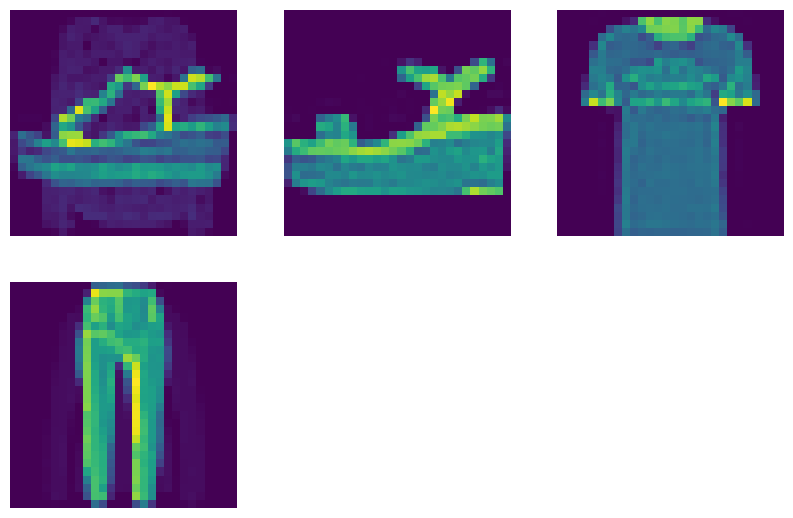

In [6]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2),
    num_parallel_calls=AUTO,
)

# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

## Model building

In [7]:

def get_training_model():
    model = keras.Sequential(
        [
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(16, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model


For the sake of reproducibility, we serialize the initial random weights of our shallow
network.

In [8]:
initial_model = get_training_model()
initial_model.save_weights("initial_weights.weights.h5")

## 1. Train the model with the mixed up dataset

In [9]:
model = get_training_model()
model.load_weights("initial_weights.weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_mu, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/2


I0000 00:00:1722956168.529473   26601 service.cc:146] XLA service 0x73c20000b180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722956168.529508   26601 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-08-06 15:56:08.572266: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-06 15:56:09.911780: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-06 15:56:11.905235: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   79/14500 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.1300 - loss: 2.2858      

I0000 00:00:1722956172.491431   26601 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14500/14500 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.6423 - loss: 1.1250 - val_accuracy: 0.8485 - val_loss: 0.4419
Epoch 2/2
14500/14500 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.8022 - loss: 0.7554 - val_accuracy: 0.8575 - val_loss: 0.3869
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8631 - loss: 0.4005
Test accuracy: 85.87%


## 2. Train the model *without* the mixed up dataset

In [10]:
model = get_training_model()
model.load_weights("initial_weights.weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Notice that we are NOT using the mixed up dataset here
model.fit(train_ds_one, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/2
14500/14500 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.6831 - loss: 0.8298 - val_accuracy: 0.8470 - val_loss: 0.4361
Epoch 2/2
14500/14500 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.8367 - loss: 0.4385 - val_accuracy: 0.8660 - val_loss: 0.3672
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8496 - loss: 0.4010
Test accuracy: 85.22%


Readers are encouraged to try out mixup on different datasets from different domains and
experiment with the lambda parameter. You are strongly advised to check out the
[original paper](https://arxiv.org/abs/1710.09412) as well - the authors present several ablation studies on mixup
showing how it can improve generalization, as well as show their results of combining
more than two images to create a single one.

## Notes

* With mixup, you can create synthetic examples — especially when you lack a large
dataset - without incurring high computational costs.
* [Label smoothing](https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/) and mixup usually do not work well together because label smoothing
already modifies the hard labels by some factor.
* mixup does not work well when you are using [Supervised Contrastive
Learning](https://arxiv.org/abs/2004.11362) (SCL) since SCL expects the true labels
during its pre-training phase.
* A few other benefits of mixup include (as described in the [paper](https://arxiv.org/abs/1710.09412)) robustness to
adversarial examples and stabilized GAN (Generative Adversarial Networks) training.
* There are a number of data augmentation techniques that extend mixup such as
[CutMix](https://arxiv.org/abs/1905.04899) and [AugMix](https://arxiv.org/abs/1912.02781).